In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

In [2]:
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from augmentations import avg_aug
from imutils.paths import list_images
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import det_curve, DetCurveDisplay, roc_curve, RocCurveDisplay

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.metrics import FalsePositives, FalseNegatives, AUC, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

from aikit.graphics.biometric_performance import performance_evaluation
from aikit.graphics.confusion_matrix import (
    plot_confusion_matrix,
    plot_system_confusion_matrix
)
from aikit.graphics.det_plot import DETPlot
from aikit.metadata import __version__ as aikit_ver
from aikit.metrics.det_curve import det_curve_pais, eer_pais
from aikit.metrics.iso_30107_3 import (
    acer,
    apcer_max,
    apcer_pais,
    bpcer,
    bpcer_ap,
    riapar
)
from aikit.metrics.scores import (
    max_error_pais_scores,
    pad_scores,
    split_attack_scores,
    split_scores
)

%load_ext autoreload
%autoreload 2

np.random.seed(42)

## Variables

In [3]:
alpha = 0.75
epochs = 200
batch_size = 16
multiclass = False
shape = (224, 224)
learning_rate = 1e-4
buffer_size = 10101101
optim_str = 'sgd' # rmsprop / sgd / adam

In [4]:
_classes = ('attack', 'bonafide') if not multiclass else ('bonafide', 'printed', 'screen')
_bf_index = _classes.index('bonafide')

datasets = {
    'flickr': '../data/02_intermediate/flickr-periocular',
    'splunk': '../data/02_intermediate/splunk-periocular'
}

output_func = 'softmax' if len(_classes) > 2 else 'sigmoid'
loss = 'categorical_crossentropy' if len(_classes) > 2 else 'binary_crossentropy'

## load dataset functions

In [5]:
def plot_confusion_matrix2(cm, class_names, figsize=(16, 16), fontsize=36, draw_zeros=True, cmap="YlGnBu_r"):
    sns.set_context("notebook", font_scale=4)
    style = {
        'axes.facecolor': "#EAEAF2",
        'axes.edgecolor': "white",
        'axes.labelcolor': ".15",
        'figure.facecolor': "white",
        'figure.edgecolor': "white",
        'grid.color': "white",
        'grid.linestyle': "-",
        'legend.facecolor': ".8",
        'legend.edgecolor': ".8",
        'text.color': ".15",
        'xtick.color': ".15",
        'ytick.color': ".15",
        'font.family': "sans-serif",
        'font.sans-serif': "Helvetica",
        'savefig.facecolor': "#EAEAF2",
        'savefig.edgecolor': "#white",
        'savefig.transparent': True,
        'eer.color': ".66"
    }
    sns.set_style(style)

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    h, w = cm.shape[:2]
    for i in range(w):
        for j in range(h):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = f"{c}/{s[0]}\n{p:.1f}%"
            elif c == 0 and not draw_zeros:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{c}\n{p:.1f}%"
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = "Ground Truth"
    cm.columns.name = "Predicted"
    _, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(cm, cmap=cmap, annot=annot, fmt="",
                          annot_kws={'size': fontsize}, ax=ax)
    fig = heatmap.get_figure()
    fig.patch.set_alpha(0)

    return fig

def _parse_function_with_DA(impath, label):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, shape)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    return image, label

def _parse_function_without_DA(impath, label):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, shape)
    image = image / 255.
    return image, label

# return tf.data
def load_dataset(
    db_dict=None, db_key='flickr', multiclass=False, 
    data_augmentation=False, shape=(224, 224), color='rgb', 
    load_csv=False, return_class_weights=False, batch_size=16
):
    
    db_dir = db_dict.get(db_key)
    _classes = ('attack', 'bonafide') if not multiclass else ('bonafide', 'print', 'screen')
    imlist = [*list_images(db_dir)]
    
    if multiclass:
        # generate multiclass_y vector
        X, y = [], []
        regex_str = "|".join(_classes)
        
        for imdir in imlist:
            regex_res = re.search(regex_str, imdir)
            regex_class = regex_res.group()
            _id_class = _classes.index(regex_class)
            X.append(imdir)
            y.append(_id_class)
        
        X = np.array(X)
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights = dict(enumerate(class_weights))
        y = tf.keras.utils.to_categorical(y)

    else:
        bf_list, att_list = [], []
        for imdir in imlist:
            if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
                bf_list.append(imdir)
            else: # identify attack class
                att_list.append(imdir)
                
        bf_y = np.ones(len(bf_list))
        att_y = np.zeros(len(att_list)) # use labelencoder here
        # split|load data into train|test|val
        X = np.concatenate([att_list, bf_list])
        y = np.concatenate([att_y, bf_y])
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights = dict(enumerate(class_weights))
        y = tf.keras.utils.to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
    
    # train dataset
    train_dataset = tf.cast(X_train, dtype=tf.string)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, tf.cast(y_train, tf.float32)))
    train_dataset = train_dataset.shuffle(buffer_size)
    train_dataset = train_dataset.map(_parse_function_with_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.batch(batch_size)
    
    # val dataset
    val_dataset = tf.cast(X_val, dtype=tf.string)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset, tf.cast(y_val, tf.float32)))
    val_dataset = val_dataset.shuffle(buffer_size)
    val_dataset = val_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.cache()
    val_dataset = val_dataset.batch(1)
    
    # test dataset
    test_dataset = tf.cast(X_test, dtype=tf.string)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, tf.cast(y_test, tf.float32)))
    test_dataset = test_dataset.shuffle(buffer_size)
    test_dataset = test_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.cache()
    test_dataset = test_dataset.batch(1)
    
    if return_class_weights:
        return train_dataset, val_dataset, test_dataset, class_weights
    else:
        return train_dataset, val_dataset, test_dataset

# How to make dataset

In [6]:
train_dataset, val_dataset, test_dataset, class_weights = load_dataset(
    db_dict=datasets, db_key='flickr', 
    batch_size=batch_size, multiclass=multiclass, 
    return_class_weights=True
)

2022-12-21 14:55:57.485936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 14:55:57.486368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 14:55:57.511364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 14:55:57.511796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 14:55:57.512461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [7]:
class_weights

{0: 0.6366742596810934, 1: 2.3291666666666666}

In [8]:
len(train_dataset), len(test_dataset), len(val_dataset)

(525, 2795, 2795)

/tmp/ipykernel_9224/1367822535.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


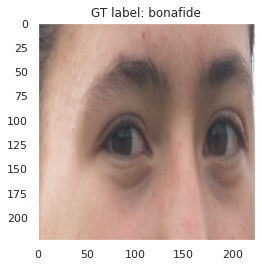

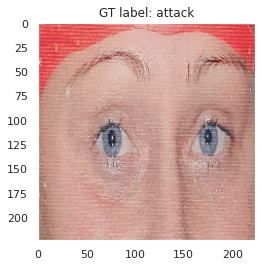

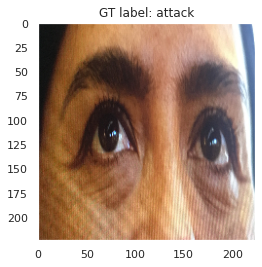

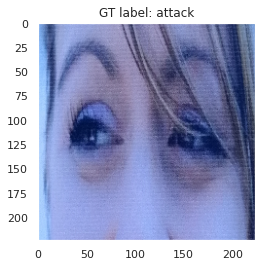

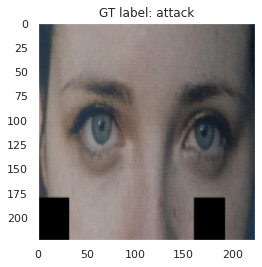

2022-12-21 14:56:00.369168: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    
    for bs in train_dataset.take(5):
        im, lb = bs

        _class_argmax = np.argmax(lb[0], axis=-1)
        plt.title(f'GT label: {_classes[_class_argmax]}')
        plt.imshow(im[0])
        plt.grid(False)
        plt.show()

In [10]:
input_shape = (*shape, 3)

model = MobileNetV2(input_shape=input_shape, alpha=alpha, include_top=False, weights=None, pooling='avg')
# model = DenseNet121(input_shape=input_shape, include_top=False, pooling='max', weights=None)
# model = MobileNetV3Small(input_shape=input_shape, alpha=alpha, include_top=False, weights=None, pooling='avg', dropout_rate=0.5)
# model = MobileNetV3Large(input_shape=input_shape, alpha=alpha, include_top=False, weights=None, pooling='avg', dropout_rate=0.5)
# model = EfficientNetB0(input_shape=input_shape, include_top=False, pooling='max', weights=None)

In [11]:
import tensorflow as tf
from math import pi

# ref: https://www.kaggle.com/code/chankhavu/keras-layers-arcface-cosface-adacos/notebook7
# ref: https://github.com/yinguobing/arcface/blob/main/train.py

class L2Normalization(tf.keras.layers.Layer):
    """This layer normalizes the inputs with l2 normalization."""

    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        inputs = tf.nn.l2_normalize(inputs, axis=1)

        return inputs

    def get_config(self):
        config = super().get_config()
        return config

class ArcLayer(tf.keras.layers.Layer):
    """Custom layer for ArcFace.
    This layer is equivalent a dense layer except the weights are normalized.
    """

    def __init__(self, units, kernel_regularizer=None, **kwargs):
        super(ArcLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=[input_shape[-1], self.units],
                                      dtype=tf.float32,
                                      initializer=tf.keras.initializers.HeNormal(),
                                      regularizer=self.kernel_regularizer,
                                      trainable=True,
                                      name='kernel')
        self.built = True

    @tf.function
    def call(self, inputs):
        weights = tf.nn.l2_normalize(self.kernel, axis=0)
        return tf.matmul(inputs, weights)

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units,
                       "kernel_regularizer": self.kernel_regularizer})
        return config

class ArcLoss(tf.keras.losses.Loss):
    """Additive angular margin loss.
    Original implementation: https://github.com/luckycallor/InsightFace-tensorflow
    """

    def __init__(self, margin=0.5, scale=64, name="arcloss"):
        """Build an additive angular margin loss object for Keras model."""
        super().__init__(name=name)
        self.margin = margin
        self.scale = scale
        self.threshold = tf.math.cos(pi - margin)
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)

        # Safe margin: https://github.com/deepinsight/insightface/issues/108
        self.safe_margin = self.sin_m * margin

    @tf.function
    def call(self, y_true, y_pred):

        # Calculate the cosine value of theta + margin.
        cos_t = y_pred
        sin_t = tf.math.sqrt(1 - tf.math.square(cos_t))

        cos_t_margin = tf.where(cos_t > self.threshold,
                                cos_t * self.cos_m - sin_t * self.sin_m,
                                cos_t - self.safe_margin)

        # The labels here had already been onehot encoded.
        mask = y_true
        cos_t_onehot = cos_t * mask
        cos_t_margin_onehot = cos_t_margin * mask

        # Calculate the final scaled logits.
        logits = (cos_t + cos_t_margin_onehot - cos_t_onehot) * self.scale

        losses = tf.nn.softmax_cross_entropy_with_logits(y_true, logits)

        return losses

    def get_config(self):
        config = super(ArcLoss, self).get_config()
        config.update({"margin": self.margin, "scale": self.scale})
        return config

In [12]:
# reg = tf.keras.regularizers.L2(1e-4)

# x = model.output
# x = L2Normalization()(x)
# x = ArcLayer(units=2, kernel_regularizer=reg)(x)
# loss = ArcLoss()
# # x = Dense(units=len(_classes), activation=output_func, use_bias=True, name="Logits")(x)

# model = Model(inputs=model.input, outputs=x)

In [13]:
x = model.output
# x = BatchNormalization()(x)
# x = Dropout(rate=0.5)(x)
x = Dense(
    units=len(_classes), activation=output_func, 
    use_bias=True, name="Logits", 
    activity_regularizer=tf.keras.regularizers.L1(1e-4),
    kernel_regularizer=tf.keras.regularizers.L2(1e-4),
)(x)

model = Model(inputs=model.input, outputs=x)

In [14]:
# model.summary()

In [15]:
f'{model.count_params():,}'

'1,384,626'

In [16]:
decay = learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def lr_exp_decay(epoch, lr):
    if epoch < 20:
        k = 0.05
        return learning_rate * tf.math.exp(-k*epoch)
    else:
        k = 0.1
        return learning_rate * tf.math.exp(-k*epoch)

In [17]:
!rm -rf models

In [18]:
callbacks = [
    # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-15, verbose=True),
    EarlyStopping(monitor='val_loss', patience=30, verbose=1),
    # LearningRateScheduler(lr_time_based_decay),
    LearningRateScheduler(lr_exp_decay),
    ModelCheckpoint(
        filepath='models/E{epoch:03d}-{val_loss:.4f}.hdf5',
        monitor='val_loss',
        mode='min',
    )
]

In [19]:
# compile model

opts = {
    'rmsprop': RMSprop(learning_rate=learning_rate, momentum=0.9),
    'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
    'adam': Adam(learning_rate=learning_rate, amsgrad=True),
}

optimizer = opts.get(optim_str)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=[
        'acc', 
        # tf.keras.metrics.Recall(),
    ], 
)

In [ ]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    history = model.fit(
        train_dataset, callbacks=callbacks,
        epochs=epochs, max_queue_size=32, 
        use_multiprocessing=True, workers=8,
        validation_data=val_dataset, shuffle=True,
        class_weight=class_weights
    )

Epoch 1/200


/tmp/ipykernel_9224/3350417194.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)
2022-12-21 14:56:04.521398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-12-21 14:56:05.149276: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-21 14:56:05.150338: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


525/525 [==============================] - 154s 284ms/step - loss: 0.6905 - acc: 0.5676 - val_loss: 0.7200 - val_acc: 0.2222 - lr: 1.0000e-04
Epoch 2/200
524/525 [============================>.] - ETA: 0s - loss: 0.6666 - acc: 0.5582

In [ ]:
# define a plot function to plot history scores
def plot_history(history, title, save_path, figsize=(12, 6), font_scale=1.5, linewidth=3.5):
    with sns.plotting_context(
        "notebook", font_scale=font_scale, rc={"lines.linewidth": linewidth}
    ):
        epochs = len(history.history["val_loss"])
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title)
        ax.set_ylabel("Loss/Acc.")
        ax.set_xlabel("Epochs")
        plt.ylim([-0.1, 1.1])
        sns.lineplot(history.history["loss"], label="Train Loss", ax=ax, linestyle='--')
        sns.lineplot(history.history["val_loss"], label="Val. Loss", ax=ax, linestyle='--')
        sns.lineplot(history.history["acc"], label="Train Acc.", ax=ax, linestyle='--')
        sns.lineplot(history.history["val_acc"], label="Val. Acc.", ax=ax, linestyle='--')
        fig.savefig(save_path)


# call plot function
plot_history(history, "Model Training Loss & Acc.", "train_plot.png")

In [ ]:
# model.evaluate(test_dataset)

In [ ]:
# identify best model and load from folder

min_hist = np.argmin(history.history.get('val_loss'))
min_hist

In [ ]:
for key in history.history.keys():
    value = history.history.get(key)[min_hist]
    print(f'{key}: {value:.4f}')

In [ ]:
y_true, y_pred, y_score = [], [], []

for im, lb in tqdm(test_dataset):
    lb = np.argmax(lb, axis=-1)[0]
    scores = model.predict(im)[0]
    pred = np.argmax(scores)
    
    y_true.append(lb)
    y_pred.append(pred)
    y_score.append(scores[_bf_index])

In [ ]:
clf = classification_report(y_true=y_true, y_pred=y_pred, digits=4, target_names=_classes)

In [ ]:
print(clf)

In [ ]:
# # fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
# fpr, fnr, thresholds = det_curve(y_true, y_score, pos_label=_bf_index)
# fig = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name='model')
# fig.plot()
# plt.show()

In [ ]:
# # fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
# fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=_bf_index)
# fig = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='model')
# fig.plot()
# plt.ylim([0.8, 1.0])
# plt.plot([0, 1], 'r--')
# plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix2(cm, _classes)
plt.plot()

In [ ]:
# agregar det multiclass

det = DETPlot(context="notebook")

y_score = np.array(y_score)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

attack_scores = y_score[ y_true != _bf_index ]
bonafide_scores = y_score[ y_true == _bf_index ]

det.set_system(attack_scores, bonafide_scores, label=f"attack")

det_plot = det.plot()

for system in det.systems:
    ths = det.systems[system]['eer_thres']
    _eer = det.systems[system]['eer']
    print(f'{system} EER: {_eer}')
    print(f'{system} EER Threshold: {ths}\n')

In [ ]:
threshold = ths
attack_scores, bonafide_scores, attack_true, bonafide_true = split_scores(y_true, y_score, bonafide_label=_bf_index)
pais_attack_scores = split_attack_scores(attack_true, attack_scores)

det_pais = det_curve_pais(attack_true, attack_scores, bonafide_scores)
eer_pais_ = eer_pais(det_pais, percentage=True)

max_eer_pais = max(eer_pais_, key=eer_pais_.get)
max_attack_scores, max_attack_pais = max_error_pais_scores(attack_true, attack_scores, threshold=threshold)

acer_ = acer(attack_true, attack_scores, bonafide_scores, threshold=threshold)
apcer_ = apcer_pais(attack_true, attack_scores, threshold=threshold, percentage=True)
bpcer_ = bpcer(bonafide_scores, threshold=threshold)
bpcer10, bpcer10thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10, percentage=True)
bpcer20, bpcer20thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 20, percentage=True)
bpcer50, bpcer50thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 50, percentage=True)
bpcer100, bpcer100thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 100, percentage=True)
bpcer200, bpcer200thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 200, percentage=True)
bpcer500, bpcer500thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 500, percentage=True)
bpcer1000, bpcer1000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 1000, percentage=True)
bpcer10000, bpcer10000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10000, percentage=True)
riapar_ = riapar(max_attack_scores, bonafide_scores, attack_threshold=threshold, bonafide_threshold=threshold)

print(
    f"        Bona Fide label: {_bf_index}: {_classes[_bf_index]}\n"
    f"            Threshold t: {threshold}\n"
    "--------------------------------------------\n"
    f"           Max EER PAIS: {max_eer_pais}: {_classes[max_eer_pais]}\n"
    f"                 EER[{max_eer_pais}]: {eer_pais_[max_eer_pais][0]}%\n"
    f"       EER threshold[{max_eer_pais}]: {eer_pais_[max_eer_pais][1]}\n"
    "--------------------------------------------\n"
    f"      Max APCER PAIS(t): {max_attack_pais}: {_classes[max_attack_pais]}\n"
    f"                ACER(t): {acer_*100}%\n"
    f"               APCER(t): {apcer_}%\n"
    f"               BPCER(t): {bpcer_*100}%\n"
    f"              RIAPAR(t): {riapar_*100}%\n"
    f"                 EER[{max_attack_pais}]: {eer_pais_[max_attack_pais][0]}%\n"
    f"       EER threshold[{max_attack_pais}]: {eer_pais_[max_attack_pais][1]}\n"
    "--------------------------------------------\n"
    f"   BPCER10(APCER=10.0%): {bpcer10}%, {bpcer10thres}\n"
    f"   BPCER20(APCER=5.00%): {bpcer20}%, {bpcer20thres}\n"
    f"   BPCER50(APCER=2.00%): {bpcer50}%, {bpcer50thres}\n"
    f"  BPCER100(APCER=1.00%): {bpcer100}%, {bpcer100thres}\n"
    f"   BPCER200(APCER=0.50%): {bpcer200}%, {bpcer200thres}\n"
    f"   BPCER500(APCER=0.20%): {bpcer500}%, {bpcer500thres}\n"
    f" BPCER1000(APCER=0.10%): {bpcer1000}%, {bpcer1000thres}\n"
    f"BPCER10000(APCER=0.01%): {bpcer10000}%, {bpcer10000thres}\n"
)

In [ ]:
# tsne exploration

In [ ]:
# # x = model.get_layer('max_pool').output
# x = model.layers[-2].output
# new_model = Model(inputs=[model.input], outputs=[x])

In [ ]:
# embs, lbs = [], []

# for im, lb in tqdm(val_dataset):
#     pred = new_model.predict(im)[0]
#     embs.append(pred)
#     lbs.append(np.argmax(lb[0]))

# embs, lbs = np.array(embs), np.array(lbs)

In [ ]:
# tsne = TSNE(n_components=2, verbose=1, random_state=42)
# comps = tsne.fit_transform(embs)

In [ ]:
# df = pd.DataFrame()
# df["y"] = lbs
# df["comp-1"] = comps[:,0]
# df["comp-2"] = comps[:,1]
# df['y2'] = df['y'].apply(lambda x: 'attack' if x == 0 else 'bonafide')

# sns.set()
# fig = plt.figure(figsize=(10, 8))

# sns.scatterplot(
#     x="comp-1", y="comp-2", hue=df.y2.tolist(),
#     # hue='y2',
#     legend='full',
#     palette=sns.color_palette("hls", 3), alpha=0.45,
#     data=df,
# )

# # plt.legend(_classes)